    0 = neutral,                0 - нейтральність
    1 = anger,                  1 - злість
    2 = contempt,               2 - зневага
    3 = disgust,                3 - огида 
    4 = fear,                   4 - страх
    5 = happy,                  5 - радість 
    6 = sadness,                6 - сум 
    7 = surprise                7 - здивування 

In [1]:
import os
from shutil import copy, move

import numpy as np
import pandas as pd
import dlib
import cv2

In [2]:
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

if not os.listdir('sorted_data'):
    print('No emotions within sorted_data detected. Creating new')
    for em in emotions:
        os.makedirs('sorted_data/'+em)

In [3]:
encoded_emotions = {t: em for t, em in enumerate(emotions)}

In [4]:
encoded_emotions

{0: 'neutral',
 1: 'anger',
 2: 'contempt',
 3: 'disgust',
 4: 'fear',
 5: 'happy',
 6: 'sadness',
 7: 'surprise'}

Get all participants of the dataset

In [5]:
img_path = 'src_images'
annotations_path = 'src_labels'
destination = 'sorted_data'

In [5]:

raw_collector = []

participants = os.listdir(img_path)
labels = os.listdir(annotations_path)
# Map emotions with folder names
emo_map = dict(zip(emotions, [f'{k:03}' for k in range(7)]))

for person in sorted(labels):
    for emotion in os.listdir(os.path.join(annotations_path, person)):
        emotion_path = os.path.join(annotations_path, person, emotion)
        if os.listdir(emotion_path):
            with open(os.path.join(emotion_path, os.listdir(emotion_path)[0]), 'r') as f:
                sample = [os.listdir(emotion_path)[0], f.read()]
                raw_collector.append(sample)


In [6]:
collector = []

for filename, emotion in raw_collector:
    file_metadata = filename.split('_')
    emotion = float(emotion.replace(' ', '').replace('e+00\n', ''))
    collector.append([file_metadata, emotion])

##### Create a backup

In [7]:
with open('backup_0.csv', 'w') as f:
    f.write(str(collector).replace('.0],', '\n').replace('[', '').replace(']', ''))

#### Move images to appropriate folders

In [8]:
for [person, collection, img, ll], label in collector:
    # Such a shit :)
    assert label > 0, f'{person, collection} has neutral ({label}) label'
    
    path_to_img_folder = os.path.join(img_path, person, collection)
    
    images = sorted(os.listdir(path_to_img_folder))
    # First 20% of images are neutral. The last (suppose 50%) are emotional.
    n = len(images)
    for i, image in enumerate(images, 1):
        img_with_path = os.path.join(path_to_img_folder, image)
        # Mark first 20% of images as neutral
        if i / n <= 0.2:
            copy(img_with_path, os.path.join(destination, encoded_emotions[0], image))
        elif i / n >= 0.4:
            copy(img_with_path, os.path.join(destination, encoded_emotions[int(label)], image))
        # Mark last 50% of images as not neutral
        #print(img_with_path, label, encoded_emotions[int(label)], round(100 * i / n, 2))
    

KeyboardInterrupt: 

Now go to folders & throw out some images manually (especially from the neutral folder)



After that pass all the images through the dlib keypoint detector to get all the facial points

In [24]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../face_landmarks.dat')


def shape_to_np(shape, dtype="int", landmarks_count=68):
    point = np.zeros((landmarks_count, 2), dtype=dtype)

    for i in range(landmarks_count):
        point[i] = (shape.part(i).x, shape.part(i).y)
    return point


def get_normalized_coords(shape):
    face_landmarks = np.zeros(shape.shape)
    
    x_max = shape[:, 0].max()
    x_min = shape[:, 0].min()
    y_max = shape[:, 1].max()
    y_min = shape[:, 1].min()
    
    face_landmarks[:, 0] = (x_max - shape[:, 0]) / (x_max - x_min)
    face_landmarks[:, 1] = (y_max - shape[:, 1]) / (y_max - y_min)
    
    return face_landmarks


def get_radius_vector(norm_shape):
    x, y = np.split(np.array(norm_shape), 2, axis=1)
    x_c, y_c = np.mean(norm_shape, axis=0)
    return np.sqrt(np.square(x - x_c) + np.square(y - y_c))


def get_angle(norm_shape):
    x, y = np.split(np.array(norm_shape), 2, axis=1)
    return np.arctan(x / y)


def get_face_landmarks(img_name, img_array, predictor):
    gray_image = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    h, w = img_array.shape[:2]
    rects = detector(gray_image, 1)
#     rad_vectors = []
#     face_landmarks = []
    for i, rect in enumerate(rects):
        # remove this "if" in case, this is not training exxample
        if i > 1:
            print(f'{img_name} seems to fail')
            break
        
        face_detector = predictor(gray_image, rect)
        shape = shape_to_np(face_detector)
        shape = get_normalized_coords(shape)
        
        radius_vector = get_radius_vector(shape)
        angle = get_angle(shape)

        return shape, radius_vector.astype(float), angle




In [11]:
#!pip install atpbar
from atpbar import atpbar

In [27]:
jsonlike = []
for emotion in atpbar(emotions, name='images'):
    for image in atpbar(os.listdir(os.path.join(destination, emotion)), name=emotion):
        imgpath = os.path.join(destination, emotion, image)
        try:
            img_array = cv2.imread(imgpath)
            face_landmarks, rad_vectors, angles = get_face_landmarks(image, img_array, predictor)
        except:
            print(f'failed on {imgpath}')
            continue
        
        current_image_collector = {'image': image, 'emotion': emotion}

        
        #print(face_landmarks[0])
        
        for i, [x, y] in enumerate(face_landmarks):
            current_image_collector.update({f'x_{i}':x})
            current_image_collector.update({f'y_{i}':y})
            current_image_collector.update({f'r_{i}':rad_vectors[i]})
            current_image_collector.update({f'a_{i}':y})

        jsonlike.append(current_image_collector)

   
        
        


VBox()

/home/yurii/Work/rd/emo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


failed on sorted_data/neutral/.DS_Store


In [30]:
df2 = pd.DataFrame(jsonlike)

In [31]:
df2.head()

,a_0,a_1,a_10,a_11,a_12,a_13,a_14,a_15,a_16,a_17,...,y_61,y_62,y_63,y_64,y_65,y_66,y_67,y_7,y_8,y_9
0,0.866071,0.727679,0.107143,0.214286,0.334821,0.464286,0.598214,0.732143,0.861607,0.933036,...,0.352679,0.343750,0.352679,0.343750,0.352679,0.343750,0.352679,0.022321,0.0,0.017857
1,0.758242,0.631868,0.076923,0.159341,0.269231,0.395604,0.527473,0.659341,0.791209,0.868132,...,0.346154,0.340659,0.346154,0.329670,0.340659,0.335165,0.340659,0.010989,0.0,0.016484
2,0.780488,0.648780,0.068293,0.146341,0.248780,0.370732,0.492683,0.614634,0.746341,0.921951,...,0.331707,0.326829,0.331707,0.307317,0.331707,0.326829,0.331707,0.019512,0.0,0.014634
3,0.784483,0.646552,0.056034,0.133621,0.241379,0.362069,0.500000,0.637931,0.780172,0.913793,...,0.362069,0.353448,0.353448,0.331897,0.353448,0.349138,0.357759,0.021552,0.0,0.008621
4,0.792829,0.669323,0.099602,0.195219,0.306773,0.418327,0.537849,0.653386,0.772908,0.892430,...,0.366534,0.354582,0.358566,0.338645,0.338645,0.330677,0.342629,0.023904,0.0,0.023904


In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4766 entries, 0 to 4765
Columns: 274 entries, a_0 to y_9
dtypes: float64(204), object(70)
memory usage: 10.0+ MB


In [ ]:
df2.describe()

In [33]:
df2 = df2.sample(frac=1)

In [34]:
df2[['a_0', 'x_0', 'y_0', 'r_0']].head()

,a_0,x_0,y_0,r_0
4279,0.756654,1.0,0.756654,[0.5258584514554413]
2976,0.744186,1.0,0.744186,[0.5528108257985824]
1023,0.783654,1.0,0.783654,[0.5478396100540174]
2835,0.842324,1.0,0.842324,[0.5832609309138563]
490,0.783673,1.0,0.783673,[0.5307376866998269]


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [36]:
label = df2['emotion']

In [37]:
le = LabelEncoder()
y = le.fit_transform(label)

df2 = df2.drop(['emotion', 'image'], axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2)

X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
X_train.shape, X_test.shape

/home/yurii/Work/rd/emo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yurii/Work/rd/emo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


((3812, 272), (954, 272))

In [39]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [41]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
pickle.dump(model, open('xgb_model.pickle', 'wb'))

Accuracy: 90.67%


#### Save trained model

In [42]:
pickle.dump(model, open('xgb_model.pickle', 'wb'))
restored = pickle.load(open("xgb_model.pickle", "rb"))

In [ ]:
#restored2 = pickle.load(open("xgb_with_rv.pickle", "rb"))

In [43]:
X_sample = X_test[-1]

In [44]:
X_sample.shape

(272,)

### Restoring the original point coordinates

In [45]:
x_c = 100
y_c = 100
w = 200
h = 200

In [46]:
y_one = model.predict(X_sample.reshape([1, 272]))

In [47]:
y_one

array([4])

In [48]:
X_sample

array([0.8394495412844036, 0.7110091743119266, 0.10091743119266056,
       0.18807339449541285, 0.2981651376146789, 0.43119266055045874,
       0.5642201834862385, 0.6926605504587156, 0.8256880733944955,
       0.9220183486238532, 0.981651376146789, 1.0, 0.5825688073394495,
       0.9862385321100917, 0.944954128440367, 0.9311926605504587,
       0.963302752293578, 0.9724770642201835, 0.9541284403669725,
       0.8990825688073395, 0.8302752293577982, 0.7431192660550459,
       0.6559633027522935, 0.44495412844036697, 0.5688073394495413,
       0.5137614678899083, 0.5, 0.481651376146789, 0.5,
       0.5137614678899083, 0.8256880733944955, 0.8348623853211009,
       0.8302752293577982, 0.8027522935779816, 0.3119266055045872,
       0.7935779816513762, 0.7981651376146789, 0.7981651376146789,
       0.8165137614678899, 0.8165137614678899, 0.8073394495412844,
       0.7844036697247706, 0.7844036697247706, 0.39908256880733944,
       0.41284403669724773, 0.1926605504587156, 0.4220183486238532

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


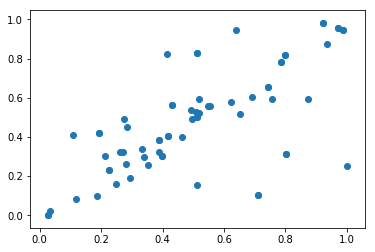

In [49]:
%time

shape = []
for k in range(0, len(X_sample), 4):
    x = X_sample[k+1] 
    y = X_sample[k+2]
    shape.append([x, y])
x_s = [s[0] for s in shape]
y_s = [s[1] for s in shape]

plt.scatter(x_s, y_s)

In [ ]:
%time

rand_ar = np.array(X_sample).reshape(68,4)
rand_ar = np.delete(rand_ar, obj=0, axis=1)

rand_ar[:,0] = - x_c + w * rand_ar[:,0]
rand_ar[:,1] = - y_c + h * rand_ar[:,1]

plt.scatter(rand_ar[:,0], rand_ar[:,1])

In [ ]:
def restore_coordinates(norm_shape, x_c, y_c, w, h):
    shape = np.array(norm_shape).reshape(68,3)
    shape = np.delete(shape, obj=0, axis=1)

    shape[:,0] = - x_c + w * rand_ar[:,0]
    shape[:,1] = - y_c + h * rand_ar[:,1]
    return shape

In [ ]:
pred = model.predict(X_sample.reshape([1, 204]))

In [ ]:
encoded_emotions[int(pred)]